In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import copy
import itertools
import os 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras.backend as K

from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

from xtx_model import BaseMLP
from xtx_config import XTX_Config
from core.losses import tf_score, score, model_score
from core.model_utils import HyperFinder

import normlization as dt_norm
import dataset as dt


Using TensorFlow backend.


## load data

In [3]:
# load dataset
dataset = dt.XTXDataset()
dataset.delete_invalid_rows()

Time series length: 2999999


In [57]:
def data_func(datas, time_steps=15, norm_window_size=10, levels=15):
    mid_price = datas.mid_rate
    n = 87
    y = mid_price[n:] - mid_price[:-n]
    x = datas.features[:-n]
    
    x = np.concatenate([x[..., i*15:i*15+levels] for i in range(4)], axis=-1)

    x, y = dt.data_sliding(x, y, time_step=time_steps+norm_window_size-1)
    (train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.split_data([x, y], split=[0.6, 0.1, 0.3], sampling=5)

    train_valid = train_x.shape[0] // 256 * 256
    val_valid = val_x.shape[0] // 256 * 256
    
    return (train_x[:train_valid], train_y[:train_valid]), (val_x[:val_valid], val_y[:val_valid]), (test_x, test_y)

### find learning_rate, momentum, weight_decay

In [89]:
finder = HyperFinder(BaseMLP, XTX_Config, dataset, data_func)

C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 17s 48us/step - loss: nan - acc: 0.1537 - val_loss: nan - val_acc: 0.0000e+00


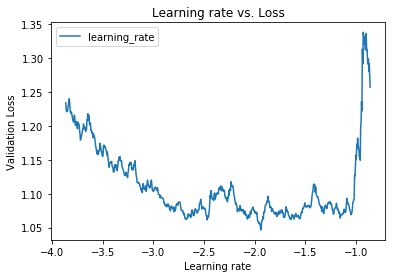

In [90]:
finder.find_lr(min_lr=1e-6, max_lr=1)

finder.vis_lr(begin=500, end=-200)

In [94]:
finder.set_best_lr(10**-2.5)

In [95]:
momentums = [0.85, 0.9, 0.95, 0.99, 0.999]
finder.find_momentum(momentums)

Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 134s 372us/step - loss: 1.0650 - acc: 0.1851 - val_loss: 0.9956 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 134s 372us/step - loss: 1.0612 - acc: 0.1857 - val_loss: 0.9951 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 132s 366us/step - loss: 1.0502 - acc: 0.1863 - val_loss: 0.9933 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 135s 374us/step - loss: 1.0406 - acc: 0.1866 - val_loss: 0.9908 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 140s 388us/step - loss: 1.1300 - acc: 0.1805 - val_loss: 1.3934 - val_acc: 0.2060


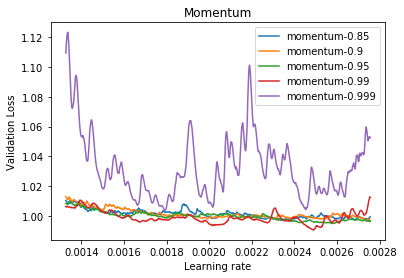

In [97]:
finder.vis_momentum(momentums, begin=500, end=-200)

In [98]:
finder.set_best_momentum(0.99)

In [102]:
weight_decays = [np.power(0.1, x) for x in np.arange(1, 7, 1)]
weight_decays.append(0)
finder.find_weight_decay(weight_decays)

C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 135s 377us/step - loss: 22.5651 - acc: 0.1875 - val_loss: 1.0002 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 137s 382us/step - loss: 8.3671 - acc: 0.1871 - val_loss: 1.0583 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 141s 391us/step - loss: 3.1008 - acc: 0.1867 - val_loss: 2.1055 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 138s 384us/step - loss: 1.3022 - acc: 0.1866 - val_loss: 1.2383 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 135s 376us/step - loss: 1.0664 - acc: 0.1865 - val_loss: 1.0161 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 135s 376us/step - loss: 1.0414 - acc: 0.1867 - val_loss: 0.9931 - val_acc: 0.2260


C:\Users\bigcat\Anaconda3\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 359680 samples, validate on 59904 samples
Epoch 1/1
359680/359680 [==============================] - 136s 379us/step - loss: 1.0407 - acc: 0.1868 - val_loss: 1.0041 - val_acc: 0.2260


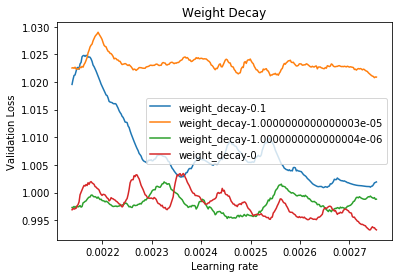

In [106]:
weight_decays = [np.power(0.1, x) for x in np.arange(1, 7, 1)]
weight_decays.append(0)
weight_decays[1:4] = []
finder.vis_weight_decay(weight_decays, begin=900, end=-200)

### MLP

In [5]:
from xtx_config import XTX_Config
mlp_model = BaseMLP(XTX_Config)
mlp_model.set_data(dataset, data_func=data_dunc)

In [ ]:
history = mlp_model.retrain()

# print('val_score:', score(val_y, mlp_model.predict(val_x)))

# print('test_score:', score(test_y, mlp_model.predict(test_x)))

In [ ]:
# search_dict = {"dropout": [x for x in np.arange(0.1, 0.9, 0.1)]}
search_dict = {"time_steps": [x for x in np.arange(10, 100, 10)], "norm_window_size": [x for x in np.arange(5, 61, 10)]}
# search_dict = {"mlp_scale": [x for x in range(1, 10)]}
val_scores, test_scores = mlp_model.parameter_search(search_dict=search_dict)